In [18]:
from loader_utils import *
import matplotlib.pyplot as plt
import numpy as np

In [19]:
username = 'eghirardo' # replace with your WRDS username
conn = wrds.Connection(wrds_username=username) # will prompt for password first time, will store credentials in .pgpass file

Loading library list...
Done


Download data and filter for valid quotes (both bid and ask sizes greater than zero)

In [20]:
ticker = 'BBY'
# start_date = '2025-05-25'
end_date = '2025-05-30'

date = end_date

In [21]:
quotes = get_taq_data(conn, ticker, date, 'quotes')
trades = get_taq_data(conn, ticker, date, 'trades')
valid_quotes_filter = (quotes.bidsiz > 0) & (quotes.asksiz > 0)
quotes_valid = quotes[valid_quotes_filter].copy()

Compute fair value (size-weighted mid-price) and mid-price

In [22]:
quotes_valid.loc[:, 'fair_value'] = (quotes_valid.bid * quotes_valid.asksiz + quotes_valid.ask * quotes_valid.bidsiz) / (quotes_valid.bidsiz + quotes_valid.asksiz)
quotes_valid.loc[:, 'mid_price'] = (quotes_valid.bid + quotes_valid.ask) / 2

Plot the trade price and the fair value over time

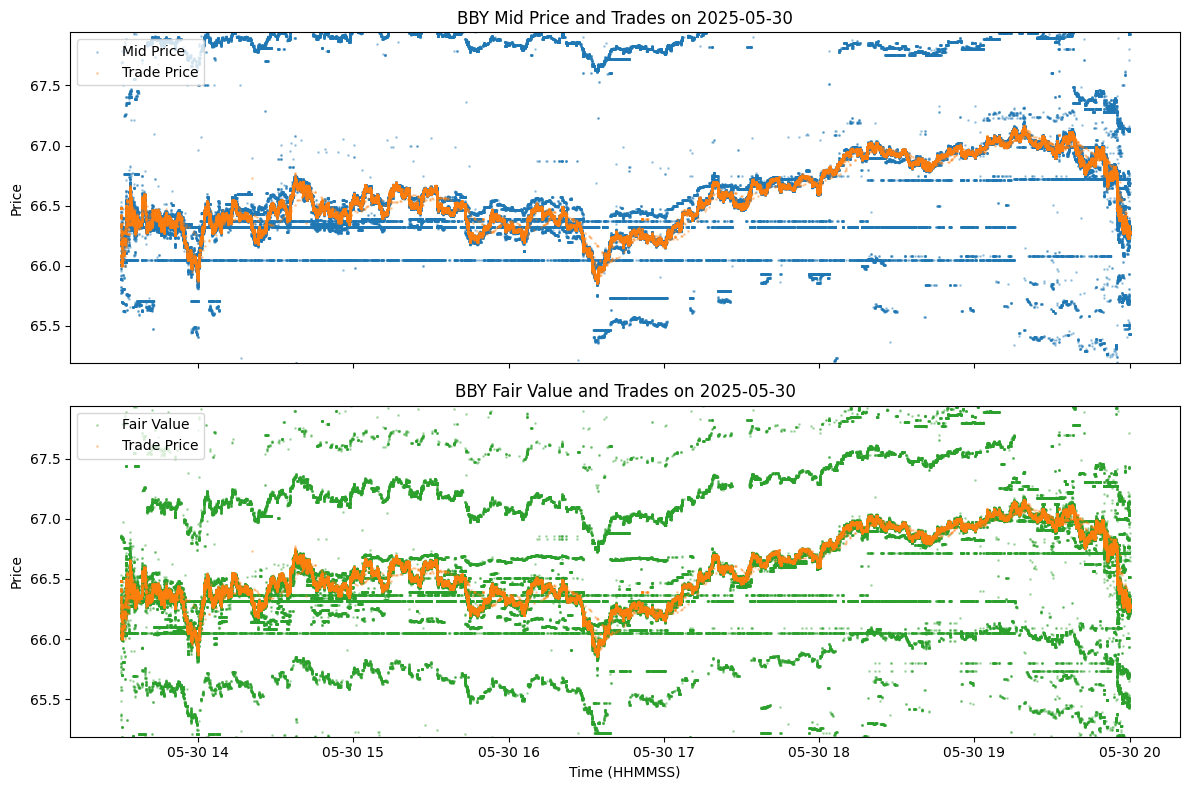

In [23]:
mean_price = trades.price.mean()
std_price = trades.price.std()
n_std = 5

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Mid-price subplot
axes[0].scatter(quotes_valid.index, quotes_valid.mid_price, label='Mid Price', color='tab:blue', alpha=0.3, s=1)
axes[0].scatter(trades.index, trades.price, label='Trade Price', color='tab:orange', alpha=0.3, s=1)
axes[0].set_ylabel('Price')
axes[0].set_ylim(mean_price - n_std * std_price, mean_price + n_std * std_price)
axes[0].set_title(f'{ticker} Mid Price and Trades on {date}')
axes[0].legend(loc='upper left')

# Fair-value subplot
axes[1].scatter(quotes_valid.index, quotes_valid.fair_value, label='Fair Value', color='tab:green', alpha=0.3, s=1)
axes[1].scatter(trades.index, trades.price, label='Trade Price', color='tab:orange', alpha=0.3, s=1)
axes[1].set_xlabel('Time (HHMMSS)')
axes[1].set_ylabel('Price')
axes[1].set_ylim(mean_price - n_std * std_price, mean_price + n_std * std_price)
axes[1].set_title(f'{ticker} Fair Value and Trades on {date}')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

From this graph, we can observe that the quotes data needs a lot more cleaning than just filtering out zero sizes. There are many outliers in the quotes data that lead to large deviations from the trade prices.

### Market liquidity plots

We merge the trades data with the fair value to compute the effective half-spread. Since we do not have the direction of the trade, we use the following formula:
$$
\text{Effective Half-Spread} = \frac{| \text{Trade Price} - \text{Fair Value} |}{\text{Fair Value}}
$$

In [24]:
merged = pd.merge_asof(trades.sort_index(), quotes_valid[['fair_value']].sort_index(), left_index=True, right_index=True, direction='backward')
merged.loc[:, 'effective_half_spread'] = np.abs(merged.price - merged.fair_value) / merged.fair_value

Plot the effective half-spread over the trading day

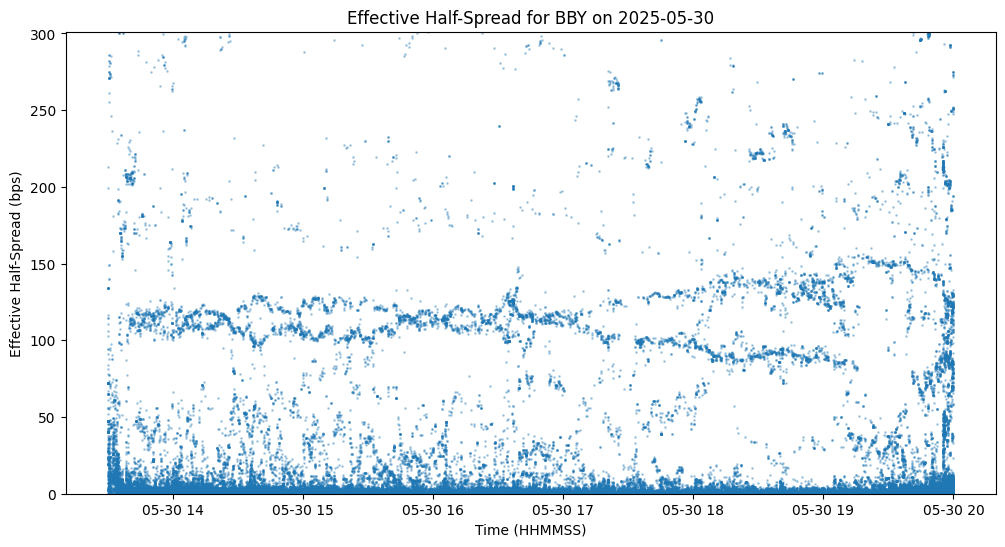

In [25]:
std_effective_half_spread = merged.effective_half_spread.std()
n_std = 3

plt.figure(figsize=(12,6))
plt.scatter(merged.index, merged.effective_half_spread * 10000, alpha=0.3, s=1)
plt.xlabel('Time (HHMMSS)')
plt.ylabel('Effective Half-Spread (bps)')
plt.ylim(0, n_std * std_effective_half_spread * 10000)
plt.title(f'Effective Half-Spread for {ticker} on {date}')
plt.show()

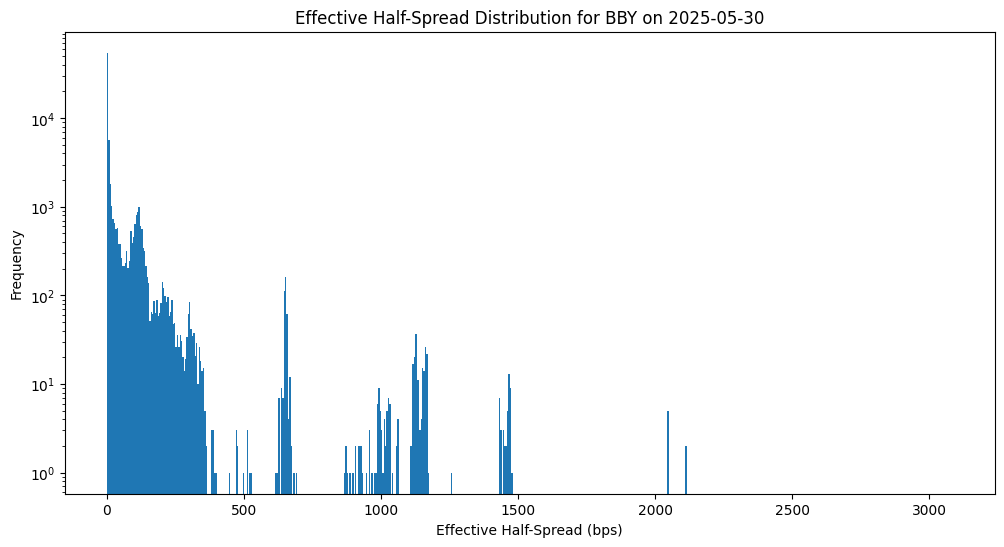

In [26]:
plt.figure(figsize=(12, 6))
plt.hist(merged.effective_half_spread*10000, cumulative=False, bins=np.arange(merged.effective_half_spread.min()*10000, merged.effective_half_spread.max()*10000+1, 5))
plt.yscale('log')
plt.xlabel('Effective Half-Spread (bps)')
plt.ylabel('Frequency')
plt.title(f'Effective Half-Spread Distribution for {ticker} on {date}')
plt.show()

We compute the spread as the difference between ask and bid prices.

In [27]:
quotes_valid.loc[:, 'spread'] = quotes_valid.ask - quotes_valid.bid
# calculate rolling mean of spread
n = 15
quotes_valid.loc[:, 'spread_ma'] = quotes_valid['spread'].rolling(f'{n}min').mean()

We infer the tick size by taking the minimum price difference observed in the quotes data.

In [28]:
prices = sorted(set(quotes.bid) | set(quotes.ask))
tick_size = min(np.diff(prices)) if len(prices) > 1 else 0

quotes_valid.loc[:, 'spread_ticks'] = quotes_valid.spread / tick_size
quotes_valid.loc[:, 'spread_ma_ticks'] = quotes_valid.spread_ma / tick_size

We plot the spread over time using a rolling mean to smooth out short-term fluctuations.

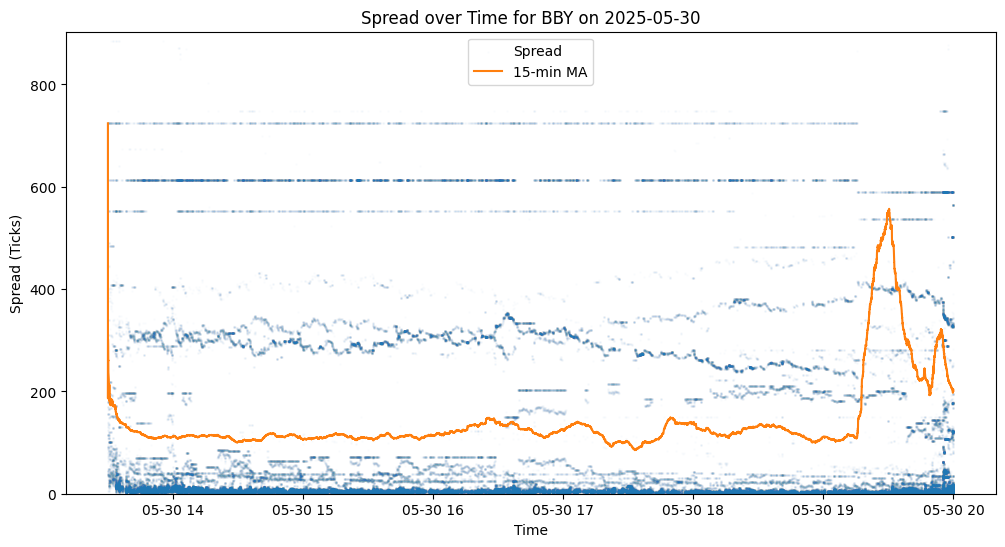

In [29]:
std_spread = quotes_valid.spread_ticks.std()
n_std = 2

plt.figure(figsize=(12, 6))
plt.scatter(quotes_valid.index, quotes_valid.spread_ticks, s=1, color='tab:blue', alpha=0.01, label='Spread')
plt.plot(quotes_valid.index, quotes_valid.spread_ma_ticks, color='tab:orange', label=f'{n}-min MA')
plt.xlabel('Time')
plt.ylabel('Spread (Ticks)')
plt.ylim(0, n_std * std_spread)
plt.title(f'Spread over Time for {ticker} on {date}')
plt.legend()
plt.show()

We plot the distribution of the spread in ticks.

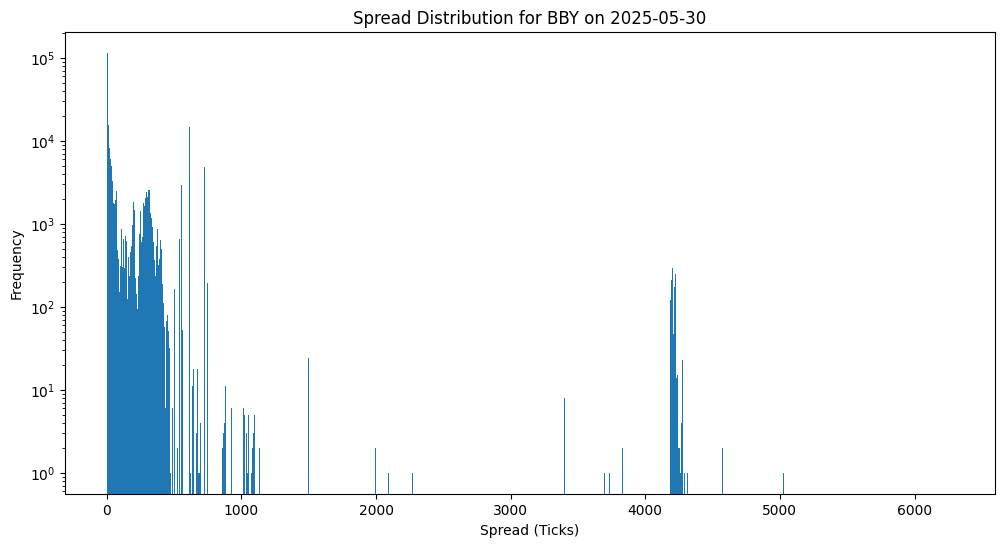

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(quotes_valid.spread_ticks, bins=list(range(int(quotes_valid.spread_ticks.min()), int(quotes_valid.spread_ticks.max()+1), 5)), cumulative=False)
plt.yscale('log')
plt.xlabel('Spread (Ticks)')
plt.ylabel('Frequency')
plt.title(f'Spread Distribution for {ticker} on {date}')
plt.show()

### Price impact plots

We are now interested in an empirical analysis of the price impact of trades. We define the price impact as:
$$
\lambda := \frac{\partial p}{\partial q}
$$

We merge the trades data with the fair value immediately after the trade to compute the price impact.

In [ ]:
merged_after = pd.merge_asof(trades.sort_index(), quotes_valid[['fair_value']].sort_index(), left_index=True, right_index=True, direction='forward')
merged_after.loc[:, 'price_impact'] = (merged_after.fair_value - merged_after.price) / merged_after.price
merged_after.loc[:, 'trade_size'] = merged_after['size'] * merged_after['price']

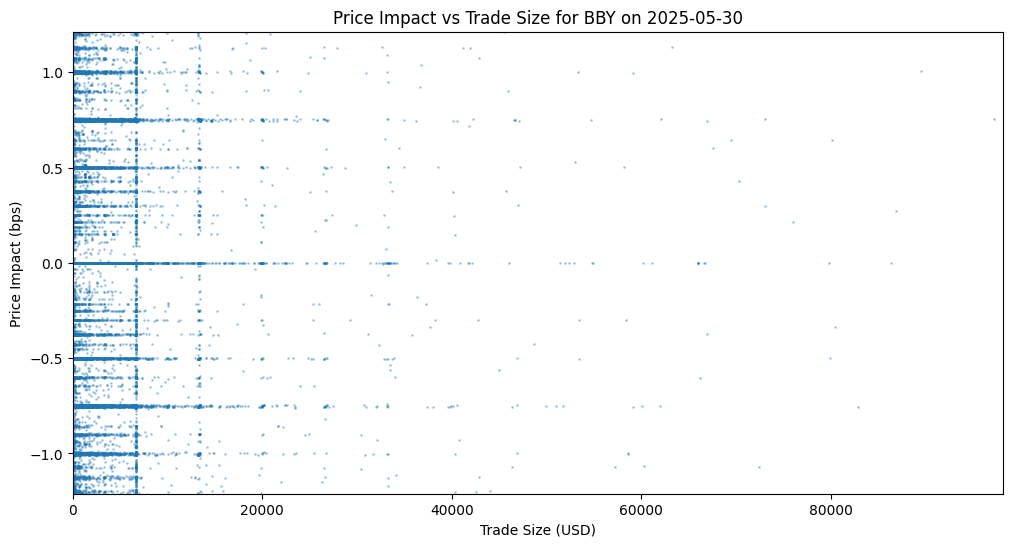

In [49]:
mean_price_impact = merged_after.price_impact.mean()
std_price_impact = merged_after.price_impact.std()
n_std = 100

std_trade_size = merged_after.trade_size.std()
n_std_size = 5


plt.figure(figsize=(12,6))
plt.scatter(merged_after.trade_size, merged_after.price_impact * 10000, alpha=0.3, s=1)
plt.xlabel('Trade Size (USD)')
plt.ylabel('Price Impact (bps)')
plt.xlim(0, n_std_size * std_trade_size)
plt.ylim(mean_price_impact - n_std * std_price_impact, mean_price_impact + n_std * std_price_impact)
plt.title(f'Price Impact vs Trade Size for {ticker} on {date}')
plt.show()